In [1]:
!pip install pyswarm

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from pyswarm import pso

RANDOM_STATE = 8420

## **Preparation**

In [3]:
vietnam_path = "dataset/data_vietnam.npz"

In [4]:
# Load arrays from the .npz file
vietnam_data = np.load(vietnam_path)

# Access individual arrays
x_vietnam = vietnam_data['x']
coordinate_vietnam = vietnam_data["coordinates"]
y_classification_vietnam = vietnam_data['y_classification']
y_regression_vietnam = vietnam_data['y_regression']
columns_vietnam = vietnam_data['columns']


In [5]:
x = x_vietnam
coordinates = coordinate_vietnam
y = y_classification_vietnam


In [6]:
x_train, x_test, coordinates_train, coordinates_test, y_train, y_test = train_test_split(x, coordinates, y, shuffle=True, random_state=RANDOM_STATE)

In [7]:
elements_column = ["na", "k", "ca2", "mg2", "fe3", "fe2", "al3", "cl", "so4", "hco3", "co3", "no2", "no3"]

In [8]:
df = pd.DataFrame(x_vietnam, columns=columns_vietnam)

In [9]:
df.columns

Index(['well_code', 'date_sampling', 'quarter', 'type_analyzing',
       'date_analyzing', 'laboratory', 'number_analyzing', 'na', 'k', 'ca2',
       'mg2', 'fe3', 'fe2', 'al3', 'cl', 'so4', 'hco3', 'co3', 'no2',
       'hardness_general', 'no3', 'hardness_temporal', 'hardness_permanent',
       'ph', 'co2_free', 'co2_depend', 'co2_infiltrate', 'sio2', 'color',
       'smell', 'tatse', 'tds105'],
      dtype='object')

In [10]:
import tensorflow as tf
from tensorflow.keras import layers, models, Input


In [11]:
tf.config.run_functions_eagerly(True)

In [12]:
import tensorflow as tf
from tensorflow.keras import layers, models, Input

## **Model Code**

### **Implementation of the Haversine Layer**

In [13]:
# Define custom Haversine layer
class HaversineLayer(layers.Layer):
    def call(self, inputs):
        lat, lon = inputs[..., 0], inputs[..., 1]
        return tf.expand_dims(tf.sqrt(lat ** 2 + lon ** 2), -1)


In [14]:
hav_inp = np.array([[1.35, 1.7],
                    [2.72, 1.6],
                    [3.4, 1.2]])

In [15]:
# Convert the numpy array to a TensorFlow tensor
input_tensor = tf.convert_to_tensor(hav_inp, dtype=tf.float32)

# Instantiate the Haversine layer
haversine_layer = HaversineLayer()

# Pass the tensor through the Haversine layer
output_tensor = haversine_layer(input_tensor)

# Print the output tensor
print(output_tensor.numpy())

[[2.1708293]
 [3.1556933]
 [3.6055512]]


In [16]:
from tensorflow.keras.utils import to_categorical


In [17]:
# One-hot encode the multiclass labels
y_train_one_hot = to_categorical(y_train)
y_test_one_hot = to_categorical(y_test)

### **Implementation of the Model**

In [32]:
class MyModel(tf.keras.Model):
    def __init__(self, layer_params):
        super(MyModel, self).__init__()
        self.num_classes = y_train_one_hot.shape[1] # num_classes
        self.num_embedding_dims = len(df.columns) + 1
        
        # Define input layers
        self.input_features = Input(shape=(len(df.columns),), name='input_features')
        self.input_coordinates = Input(shape=(2,), name='input_coordinates')
        
        # Define Embedding Layer
        self.embedding = layers.Dense(self.num_embedding_dims, activation='relu', name='embedding')
        
        # Define custom Haversine layer
        self.haversine_layer = HaversineLayer()
        
        # Define other layers
        self.concat_layer = layers.Concatenate()
        self.reshape_layer = layers.Reshape((1, self.num_embedding_dims + 1))
        self.multi_head_attention = layers.MultiHeadAttention(num_heads=2, key_dim=self.num_embedding_dims + 1)
        self.flatten_layer = layers.Flatten()
        self.space_conv = layers.Conv1D(layer_params[0], 3, activation='relu')
        self.global_pooling_layer = layers.GlobalMaxPooling1D()
        self.dense_layer1 = layers.Dense(layer_params[1], activation='relu') # 128
        self.dense_layer2 = layers.Dense(layer_params[2], activation='relu') # 64
        self.output_layer = layers.Dense(self.num_classes, activation='softmax')
        
    def call(self, inputs):
        # Separate inputs
        input_features, input_coordinates = inputs
        # print("Input features Shape: ", input_features.shape)
        # print("Input coordinates Shape: ", input_coordinates.shape)
        
        # Embedding Layer
        embedding_output = self.embedding(input_features)
        
        # Haversine layer
        haversine_output = self.haversine_layer(input_coordinates)
        # print("Haversine layer output shape: ", haversine_output.shape)
        
        # Concatenate features with haversine output
        combined_features = self.concat_layer([embedding_output, haversine_output])
        # print("Combined Features Shape: ", combined_features.shape)
        
        # Reshape features for attention
        reshaped_features_for_attention = self.reshape_layer(combined_features)
        # print("Reshaped Features Shape: ", reshaped_features_for_attention.shape)
        
        # Multi-head attention
        multi_head_attention = self.multi_head_attention(reshaped_features_for_attention, reshaped_features_for_attention)
        # print("Attention Layer Shape: ", multi_head_attention.shape)
        
        # Flatten and concatenate attention output with features
        flattened_attention = self.flatten_layer(multi_head_attention)
        # print("Flattened Layer shape: ", flattened_attention.shape)
        
        concat_features = self.concat_layer([flattened_attention, combined_features])
        # print("Concat Features Shape: ", concat_features.shape)
        
        # Expand dimensions for convolution
        concat_features = tf.expand_dims(concat_features, axis=-1)
        # print("Expand Dims Features shape: ", concat_features.shape)
        
        # Convolutional layer
        space_conv = self.space_conv(concat_features)
        # print("Convolution Layer Shape: ", space_conv.shape)
        
        # Global max pooling
        pooled = self.global_pooling_layer(space_conv)
        # print("Pooling Layer Shape: ", pooled.shape)
        
        # Fully connected layers
        dense1 = self.dense_layer1(pooled)
        dense2 = self.dense_layer2(dense1)
        
        # Output layer
        output = self.output_layer(dense2)
        # print("Output Shape: ", output.shape)
        
        return output

### **Training of the Model**

In [33]:
def create_model(layer_params):
    model = MyModel(layer_params)
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [34]:
def train_network(layer_params):
    model = create_model(layer_params)
    hst = model.fit([x_train, coordinates_train], y_train_one_hot, epochs=2, batch_size=32, validation_split=0.15, verbose=1, shuffle=True)
    return 1 - hst.history['accuracy'][-1]

#### **Incorporation of PSO Optimization (Function imported from PySwarm Library**

In [35]:
lb = [16, 32, 64]
ub = [64, 128, 128]

xopt, fopt = pso(train_network, lb, ub, swarmsize=5, omega=0.5, phip=0.5, phig=1.0, maxiter=30, minstep=1)

Epoch 1/2
43/43 [==============================] - 1s 32ms/step - loss: 1.9333 - accuracy: 0.2715 - val_loss: 1.5549 - val_accuracy: 0.3485
Epoch 2/2
43/43 [==============================] - 1s 31ms/step - loss: 1.5181 - accuracy: 0.3463 - val_loss: 1.5002 - val_accuracy: 0.3527
Epoch 1/2
43/43 [==============================] - 1s 32ms/step - loss: 2.0884 - accuracy: 0.3140 - val_loss: 1.6453 - val_accuracy: 0.3485
Epoch 2/2
43/43 [==============================] - 1s 31ms/step - loss: 1.5328 - accuracy: 0.3302 - val_loss: 1.5038 - val_accuracy: 0.3485
Epoch 1/2
43/43 [==============================] - 2s 35ms/step - loss: 1.9134 - accuracy: 0.2700 - val_loss: 1.5155 - val_accuracy: 0.3485
Epoch 2/2
43/43 [==============================] - 1s 34ms/step - loss: 1.5213 - accuracy: 0.3316 - val_loss: 1.5105 - val_accuracy: 0.3527
Epoch 1/2
43/43 [==============================] - 1s 33ms/step - loss: 2.3729 - accuracy: 0.3302 - val_loss: 1.7228 - val_accuracy: 0.3485
Epoch 2/2
43/43 [===

#### **Results of the PSO Optimized Hyperparameters**

In [37]:
# The optimized parameters
print("The otpimized parameters are:")
print("Hidden Channels Space Convolution: ", int(xopt[0]))
print("Hidden Dims Dense Layer1: ", int(xopt[1]))
print("Hidden Dims Dense Layer2: ", int(xopt[2]))

The otpimized parameters are:
Hidden Channels Space Convolution:  35
Hidden Dims Dense Layer1:  110
Hidden Dims Dense Layer2:  100


### **Running of the Model with Optimized Hyperparameters**

In [40]:
layer_params = [35, 110, 100]

# Instantiate the model
model = MyModel(layer_params)

In [41]:
# Compile the model
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])


In [42]:
# Train the model
history = model.fit([x_train, coordinates_train], y_train_one_hot, epochs=10, batch_size=32, validation_split=0.15, verbose=1, shuffle=True)

Epoch 1/10
43/43 [==============================] - 1s 33ms/step - loss: 2.9121 - accuracy: 0.2487 - val_loss: 1.6479 - val_accuracy: 0.3444
Epoch 2/10
43/43 [==============================] - 1s 32ms/step - loss: 1.5408 - accuracy: 0.3324 - val_loss: 1.5012 - val_accuracy: 0.3444
Epoch 3/10
43/43 [==============================] - 1s 32ms/step - loss: 1.5151 - accuracy: 0.3324 - val_loss: 1.5046 - val_accuracy: 0.3444
Epoch 4/10
43/43 [==============================] - 1s 32ms/step - loss: 1.5115 - accuracy: 0.3368 - val_loss: 1.4933 - val_accuracy: 0.3527
Epoch 5/10
43/43 [==============================] - 1s 32ms/step - loss: 1.5093 - accuracy: 0.3419 - val_loss: 1.4947 - val_accuracy: 0.3527
Epoch 6/10
43/43 [==============================] - 1s 32ms/step - loss: 1.5069 - accuracy: 0.3441 - val_loss: 1.4924 - val_accuracy: 0.3734
Epoch 7/10
43/43 [==============================] - 1s 32ms/step - loss: 1.5070 - accuracy: 0.3595 - val_loss: 1.4871 - val_accuracy: 0.3610
Epoch 8/10
43

In [43]:
model.summary()

Model: "my_model_174"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Dense)           multiple                  1089      
                                                                 
 haversine_layer_175 (Havers  multiple                 0         
 ineLayer)                                                       
                                                                 
 concatenate_174 (Concatenat  multiple                 0         
 e)                                                              
                                                                 
 reshape_174 (Reshape)       multiple                  0         
                                                                 
 multi_head_attention_174 (M  multiple                 9486      
 ultiHeadAttention)                                              
                                                      

### **Visualization of the Results**

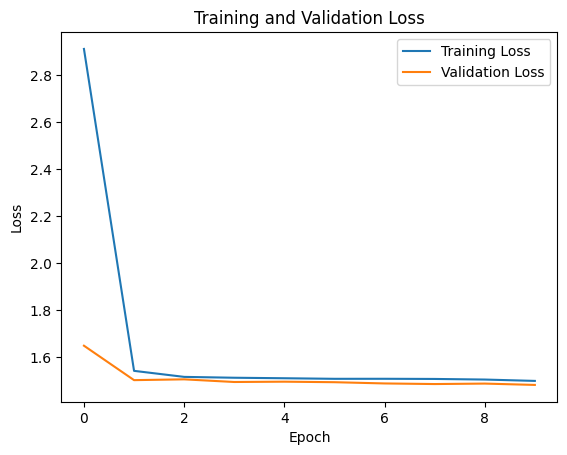

In [44]:
# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [45]:
# Predict classes for test set
y_pred = model.predict([x_test, coordinates_test])
y_pred_classes = np.argmax(y_pred, axis=1)

17/17 [==============================] - 0s 8ms/step


In [46]:
# Convert one-hot encoded labels to class labels
y_test_classes = np.argmax(y_test_one_hot, axis=1)

In [47]:
# Create confusion matrix
conf_matrix = confusion_matrix(y_test_classes, y_pred_classes)

In [48]:
classes = [0, 1, 2, 3, 4]

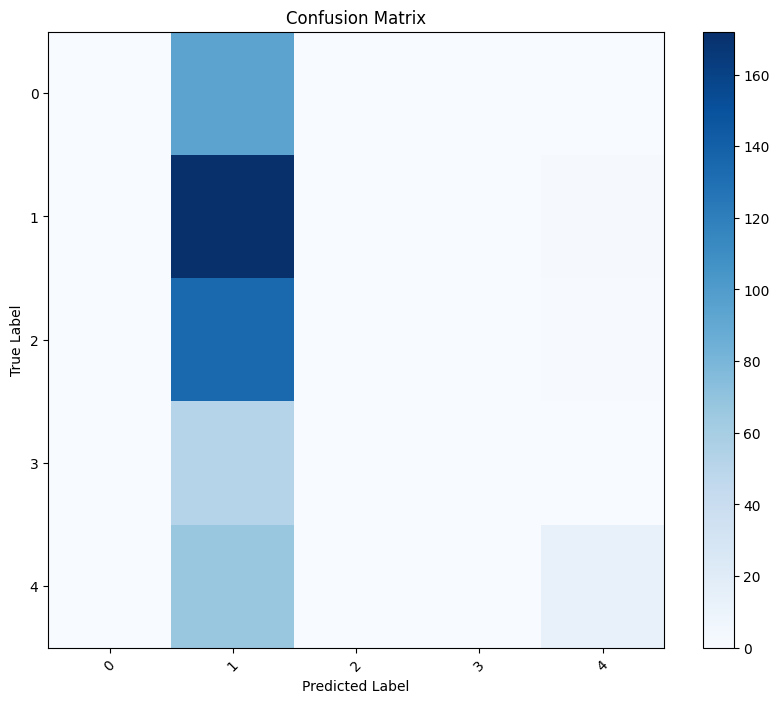

In [49]:
# Plot confusion matrix
plt.figure(figsize=(10, 8))
plt.imshow(conf_matrix, cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks(np.arange(len(classes)), classes, rotation=45)
plt.yticks(np.arange(len(classes)), classes)
plt.show()

## **Ablation Studies**

### **Haversine Layer**

In [48]:
class MyModelASHaversine(tf.keras.Model):
    def __init__(self, num_classes):
        super(MyModelASHaversine, self).__init__()
        self.num_classes = num_classes
        self.num_embedding_dims = len(df.columns) + 1
        
        # Define input layers
        self.input_features = Input(shape=(len(df.columns),), name='input_features')
        self.input_coordinates = Input(shape=(2,), name='input_coordinates')
        
        # Define Embedding Layer
        self.embedding = layers.Dense(self.num_embedding_dims, activation='relu', name='embedding')
        
        # Define custom Haversine layer
        self.haversine_layer = HaversineLayer()
        
        # Define other layers
        self.concat_layer = layers.Concatenate()
        self.reshape_layer = layers.Reshape((1, self.num_embedding_dims + 1))
        self.multi_head_attention = layers.MultiHeadAttention(num_heads=2, key_dim=self.num_embedding_dims + 1)
        self.flatten_layer = layers.Flatten()
        self.space_conv = layers.Conv1D(64, 3, activation='relu')
        self.global_pooling_layer = layers.GlobalMaxPooling1D()
        self.dense_layer1 = layers.Dense(128, activation='relu')
        self.dense_layer2 = layers.Dense(64, activation='relu')
        self.output_layer = layers.Dense(num_classes, activation='softmax')
        
    def call(self, inputs):
        # Separate inputs
        input_features, input_coordinates = inputs
        
        # Embedding Layer
        embedding_output = self.embedding(input_features)
        
        # Haversine layer
        haversine_output = input_coordinates
        
        # Concatenate features with haversine output
        combined_features = self.concat_layer([input_features[:, :embedding_output.shape[1]-1], haversine_output])
        
        # Reshape features for attention
        reshaped_features_for_attention = self.reshape_layer(combined_features)
        
        # Multi-head attention
        multi_head_attention = self.multi_head_attention(reshaped_features_for_attention, reshaped_features_for_attention)
        
        # Flatten and concatenate attention output with features
        flattened_attention = self.flatten_layer(multi_head_attention)
        
        concat_features = self.concat_layer([flattened_attention, combined_features])
        
        # Expand dimensions for convolution
        concat_features = tf.expand_dims(concat_features, axis=-1)
        
        # Convolutional layer
        space_conv = self.space_conv(concat_features)
        
        # Global max pooling
        pooled = self.global_pooling_layer(space_conv)
        
        # Fully connected layers
        dense1 = self.dense_layer1(pooled)
        dense2 = self.dense_layer2(dense1)
        
        # Output layer
        output = self.output_layer(dense2)
        
        return output

In [49]:
from tensorflow.keras.utils import to_categorical


In [50]:
# One-hot encode the multiclass labels
y_train_one_hot = to_categorical(y_train)
y_test_one_hot = to_categorical(y_test)

In [51]:
# Instantiate the model
model = MyModelASHaversine(num_classes=y_train_one_hot.shape[1])

In [52]:
# Compile the model
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])


In [53]:
# Train the model
history = model.fit([x_train, coordinates_train], y_train_one_hot, epochs=2000, batch_size=32, validation_split=0.15, verbose=1, shuffle=True)

 3/43 [=>............................] - ETA: 1s - loss: 6.1820 - accuracy: 0.1146WARNING:tensorflow:Gradients do not exist for variables ['my_model_as_haversine/embedding/kernel:0', 'my_model_as_haversine/embedding/bias:0'] when minimizing the loss. If you're using `model.compile()`, did you forget to provide a `loss` argument?


C:\Users\DELL\anaconda3\lib\site-packages\tensorflow\python\data\ops\structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


43/43 [==============================] - 2s 35ms/step - loss: 3.3058 - accuracy: 0.2428 - val_loss: 1.6830 - val_accuracy: 0.2075


### **Attention Layer**

In [54]:
class MyModelASAttention(tf.keras.Model):
    def __init__(self, num_classes):
        super(MyModelASAttention, self).__init__()
        self.num_classes = num_classes
        self.num_embedding_dims = len(df.columns) + 1
        
        # Define input layers
        self.input_features = Input(shape=(len(df.columns),), name='input_features')
        self.input_coordinates = Input(shape=(2,), name='input_coordinates')
        
        # Define Embedding Layer
        self.embedding = layers.Dense(self.num_embedding_dims, activation='relu', name='embedding')
        
        # Define custom Haversine layer
        self.haversine_layer = HaversineLayer()
        
        # Define other layers
        self.concat_layer = layers.Concatenate()
        self.reshape_layer = layers.Reshape((1, self.num_embedding_dims + 1))
        # self.multi_head_attention = layers.MultiHeadAttention(num_heads=2, key_dim=len(df.columns) + 1)
        self.flatten_layer = layers.Flatten()
        self.space_conv = layers.Conv1D(64, 3, activation='relu')
        self.global_pooling_layer = layers.GlobalMaxPooling1D()
        self.dense_layer1 = layers.Dense(128, activation='relu')
        self.dense_layer2 = layers.Dense(64, activation='relu')
        self.output_layer = layers.Dense(num_classes, activation='softmax')
        
    def call(self, inputs):
        # Separate inputs
        input_features, input_coordinates = inputs
        
        # Embedding Layer
        embedding_output = self.embedding(input_features)
        
        # Haversine layer
        haversine_output = self.haversine_layer(input_coordinates)
        
        # Concatenate features with haversine output
        combined_features = self.concat_layer([embedding_output, haversine_output])
        
        # Reshape features for attention
        reshaped_features_for_attention = self.reshape_layer(combined_features)
        
        # Multi-head attention
        # multi_head_attention = self.multi_head_attention(reshaped_features_for_attention, reshaped_features_for_attention)
        
        # Flatten and concatenate attention output with features
        flattened_attention = self.flatten_layer(reshaped_features_for_attention)
        
        concat_features = self.concat_layer([flattened_attention, combined_features])
        
        # Expand dimensions for convolution
        concat_features = tf.expand_dims(concat_features, axis=-1)
        
        # Convolutional layer
        space_conv = self.space_conv(concat_features)
        
        # Global max pooling
        pooled = self.global_pooling_layer(space_conv)
        
        # Fully connected layers
        dense1 = self.dense_layer1(pooled)
        dense2 = self.dense_layer2(dense1)
        
        # Output layer
        output = self.output_layer(dense2)
        # print("Output Shape: ", output.shape)
        
        return output

In [55]:
# Instantiate the model
model = MyModelASAttention(num_classes=y_train_one_hot.shape[1])

In [56]:
# Compile the model
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])


In [57]:
# Train the model
history = model.fit([x_train, coordinates_train], y_train_one_hot, epochs=2000, batch_size=32, validation_split=0.15, verbose=1, shuffle=True)

43/43 [==============================] - 1s 23ms/step - loss: 2.8642 - accuracy: 0.2091 - val_loss: 1.6570 - val_accuracy: 0.2075


### **Dimensional Expansion**

In [58]:
class MyModelASDimExp(tf.keras.Model):
    def __init__(self, num_classes):
        super(MyModelASDimExp, self).__init__()
        self.num_classes = num_classes
        self.num_embedding_dims = len(df.columns) + 1
        
        # Define input layers
        self.input_features = Input(shape=(len(df.columns),), name='input_features')
        self.input_coordinates = Input(shape=(2,), name='input_coordinates')
        
        # Define Embedding Layer
        self.embedding = layers.Dense(self.num_embedding_dims, activation='relu', name='embedding')
        
        # Define custom Haversine layer
        self.haversine_layer = HaversineLayer()
        
        # Define other layers
        self.concat_layer = layers.Concatenate()
        self.reshape_layer = layers.Reshape((1, self.num_embedding_dims + 1))
        self.multi_head_attention = layers.MultiHeadAttention(num_heads=2, key_dim=self.num_embedding_dims + 1)
        self.flatten_layer = layers.Flatten()
        self.space_conv = layers.Conv1D(64, 3, activation='relu')
        self.global_pooling_layer = layers.GlobalMaxPooling1D()
        self.dense_layer1 = layers.Dense(128, activation='relu')
        self.dense_layer2 = layers.Dense(64, activation='relu')
        self.output_layer = layers.Dense(num_classes, activation='softmax')
        
    def call(self, inputs):
        # Separate inputs
        input_features, input_coordinates = inputs
        
        # Embedding Layer
        embedding_output = self.embedding(input_features)
        
        # Haversine layer
        haversine_output = self.haversine_layer(input_coordinates)
        
        # Concatenate features with haversine output
        combined_features = self.concat_layer([embedding_output, haversine_output])
        
        # Reshape features for attention
        reshaped_features_for_attention = self.reshape_layer(combined_features)
        
        # Multi-head attention
        multi_head_attention = self.multi_head_attention(reshaped_features_for_attention, reshaped_features_for_attention)
        
        # Flatten and concatenate attention output with features
        flattened_attention = self.flatten_layer(multi_head_attention)
        
        # concat_features = self.concat_layer([flattened_attention, combined_features])
        
        # Expand dimensions for convolution
        concat_features = tf.expand_dims(flattened_attention, axis=-1)
        
        # Convolutional layer
        space_conv = self.space_conv(concat_features)
        
        # Global max pooling
        pooled = self.global_pooling_layer(space_conv)
        
        # Fully connected layers
        dense1 = self.dense_layer1(pooled)
        dense2 = self.dense_layer2(dense1)
        
        # Output layer
        output = self.output_layer(dense2)
        # print("Output Shape: ", output.shape)
        
        return output

In [59]:
# Instantiate the model
model = MyModelASDimExp(num_classes=y_train_one_hot.shape[1])

In [60]:
# Compile the model
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])


In [61]:
# Train the model
history = model.fit([x_train, coordinates_train], y_train_one_hot, epochs=2000, batch_size=32, validation_split=0.15, verbose=1, shuffle=True)

43/43 [==============================] - 1s 32ms/step - loss: 1.5978 - accuracy: 0.2597 - val_loss: 1.5176 - val_accuracy: 0.3444


### **Spatial Convolution**

In [70]:
class MyModelASSpatialConv(tf.keras.Model):
    def __init__(self, num_classes):
        super(MyModelASSpatialConv, self).__init__()
        self.num_classes = num_classes
        self.num_embedding_dims = len(df.columns) + 1
        
        # Define input layers
        self.input_features = Input(shape=(len(df.columns),), name='input_features')
        self.input_coordinates = Input(shape=(2,), name='input_coordinates')
        
        # Define Embedding Layer
        self.embedding = layers.Dense(self.num_embedding_dims, activation='relu', name='embedding')
        
        # Define custom Haversine layer
        self.haversine_layer = HaversineLayer()
        
        # Define other layers
        self.concat_layer = layers.Concatenate()
        self.reshape_layer = layers.Reshape((1, self.num_embedding_dims + 1))
        self.multi_head_attention = layers.MultiHeadAttention(num_heads=2, key_dim=self.num_embedding_dims + 1)
        self.flatten_layer = layers.Flatten()
        self.space_conv = layers.Conv1D(64, 3, activation='relu')
        self.global_pooling_layer = layers.GlobalMaxPooling1D()
        self.dense_layer1 = layers.Dense(128, activation='relu')
        self.dense_layer2 = layers.Dense(64, activation='relu')
        self.output_layer = layers.Dense(num_classes, activation='softmax')
        
    def call(self, inputs):
        # Separate inputs
        input_features, input_coordinates = inputs
        
        # Embedding Layer
        embedding_output = self.embedding(input_features)
        
        # Haversine layer
        haversine_output = self.haversine_layer(input_coordinates)
        
        # Concatenate features with haversine output
        combined_features = self.concat_layer([embedding_output, haversine_output])
        
        # Reshape features for attention
        reshaped_features_for_attention = self.reshape_layer(combined_features)
        
        # Multi-head attention
        multi_head_attention = self.multi_head_attention(reshaped_features_for_attention, reshaped_features_for_attention)
        
        # Flatten and concatenate attention output with features
        flattened_attention = self.flatten_layer(multi_head_attention)
        
        concat_features = self.concat_layer([flattened_attention, combined_features])
        
        # Expand dimensions for convolution
        # concat_features = tf.expand_dims(concat_features, axis=-1)
        
        # Convolutional layer
        # space_conv = self.space_conv(concat_features)
        
        # Global max pooling
        # pooled = self.global_pooling_layer(space_conv)
        
        # Fully connected layers
        dense1 = self.dense_layer1(concat_features)
        dense2 = self.dense_layer2(dense1)
        
        # Output layer
        output = self.output_layer(dense2)
        # print("Output Shape: ", output.shape)
        
        return output

In [71]:
# Instantiate the model
model = MyModelASSpatialConv(num_classes=y_train_one_hot.shape[1])

In [72]:
# Compile the model
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])


In [73]:
# Train the model
history = model.fit([x_train, coordinates_train], y_train_one_hot, epochs=2000, batch_size=32, validation_split=0.15, verbose=1, shuffle=True)

43/43 [==============================] - 1s 27ms/step - loss: 7.4441 - accuracy: 0.1431 - val_loss: 3.4829 - val_accuracy: 0.0996


### **Spatial Pooling**

In [66]:
class MyModelASSpatialPool(tf.keras.Model):
    def __init__(self, num_classes):
        super(MyModelASSpatialPool, self).__init__()
        self.num_classes = num_classes
        self.num_embedding_dims = len(df.columns) + 1
        
        # Define input layers
        self.input_features = Input(shape=(len(df.columns),), name='input_features')
        self.input_coordinates = Input(shape=(2,), name='input_coordinates')
        
        # Define Embedding Layer
        self.embedding = layers.Dense(self.num_embedding_dims, activation='relu', name='embedding')
        
        # Define custom Haversine layer
        self.haversine_layer = HaversineLayer()
        
        # Define other layers
        self.concat_layer = layers.Concatenate()
        self.reshape_layer = layers.Reshape((1, self.num_embedding_dims + 1))
        self.multi_head_attention = layers.MultiHeadAttention(num_heads=2, key_dim=self.num_embedding_dims + 1)
        self.flatten_layer = layers.Flatten()
        self.space_conv = layers.Conv1D(64, 3, activation='relu')
        self.global_pooling_layer = layers.GlobalMaxPooling1D()
        self.dense_layer1 = layers.Dense(128, activation='relu')
        self.dense_layer2 = layers.Dense(64, activation='relu')
        self.output_layer = layers.Dense(num_classes, activation='softmax')
        
    def call(self, inputs):
        # Separate inputs
        input_features, input_coordinates = inputs
        
        # Embedding Layer
        embedding_output = self.embedding(input_features)
        
        # Haversine layer
        haversine_output = self.haversine_layer(input_coordinates)
        
        # Concatenate features with haversine output
        combined_features = self.concat_layer([embedding_output, haversine_output])
        
        # Reshape features for attention
        reshaped_features_for_attention = self.reshape_layer(combined_features)
        
        # Multi-head attention
        multi_head_attention = self.multi_head_attention(reshaped_features_for_attention, reshaped_features_for_attention)
        
        # Flatten and concatenate attention output with features
        flattened_attention = self.flatten_layer(multi_head_attention)
        
        concat_features = self.concat_layer([flattened_attention, combined_features])
        
        # Expand dimensions for convolution
        concat_features = tf.expand_dims(concat_features, axis=-1)
        
        # Convolutional layer
        space_conv = self.space_conv(concat_features)
        
        pooled = tf.reshape(space_conv, (space_conv.shape[0], space_conv.shape[1] * space_conv.shape[2]))
        
        # Global max pooling
        # pooled = self.global_pooling_layer(space_conv)
        
        # Fully connected layers
        dense1 = self.dense_layer1(pooled)
        dense2 = self.dense_layer2(dense1)
        
        # Output layer
        output = self.output_layer(dense2)
        # print("Output Shape: ", output.shape)
        
        return output

In [67]:
# Instantiate the model
model = MyModelASSpatialPool(num_classes=y_train_one_hot.shape[1])

In [68]:
# Compile the model
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])


In [69]:
# Train the model
history = model.fit([x_train, coordinates_train], y_train_one_hot, epochs=2000, batch_size=32, validation_split=0.15, verbose=1, shuffle=True)

43/43 [==============================] - 1s 33ms/step - loss: 1.5281 - accuracy: 0.3485 - val_loss: 1.4901 - val_accuracy: 0.3734
